Sahar Maleki


In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d jangedoo/utkface-new
!ls *.zip

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:15<00:00, 24.7MB/s]
100% 331M/331M [00:15<00:00, 22.5MB/s]
utkface-new.zip


In [4]:
!unzip utkface-new.zip -d UTKFace
!ls UTKFace

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.

In [5]:
for file in os.listdir('UTKFace'):
    print(file)

UTKFace
utkface_aligned_cropped
crop_part1


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda:0 device.


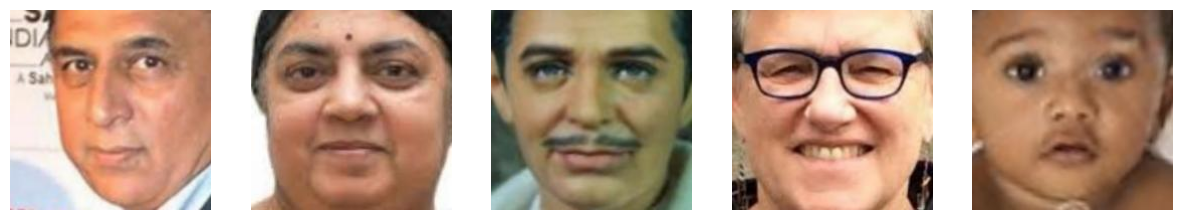

In [7]:
image_dir = '/content/UTKFace/UTKFace'
plt.figure(figsize=(15, 15))
num_images = 5

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

for i in range(min(num_images, len(image_files))):
  image_path = os.path.join(image_dir, image_files[i])

  try:
    img = mimg.imread(image_path)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis('off')
  except Exception as e:
    print(f"Error displaying image {image_files[i]}: {e}")

plt.show()

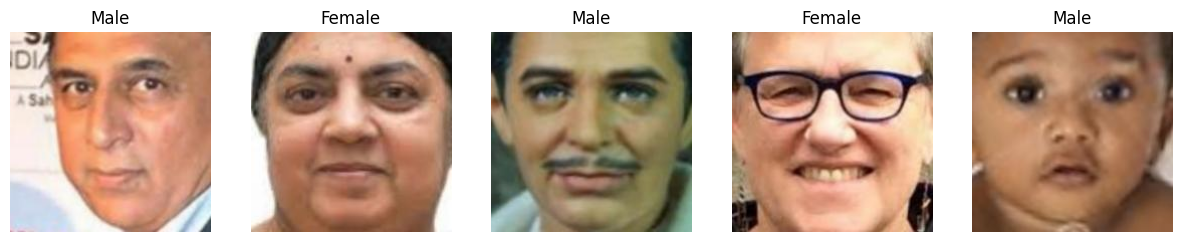

In [8]:
image_dir = '/content/UTKFace/UTKFace'
plt.figure(figsize=(15, 15))
num_images = 5

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

for i in range(min(num_images, len(image_files))):
  image_path = os.path.join(image_dir, image_files[i])
  try:
    img = mimg.imread(image_path)
    filename = os.path.basename(image_path)
    parts = filename.split('_')
    if len(parts) >= 2:
        gender = int(parts[1])
        gender_label = "Male" if gender == 0 else "Female"
    else:
        gender_label = "Unknown"

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.title(gender_label)
    plt.axis('off')
  except Exception as e:
    print(f"Error displaying image {image_files[i]}: {e}")

plt.show()

In [21]:
class LoadDataset(Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = torch.FloatTensor(images.reshape(len(images), -1))
            if isinstance(labels[0], str):
                unique_labels = list(set(labels))
                label_mapping = {label: i for i, label in enumerate(unique_labels)}
                self.labels = torch.LongTensor([label_mapping[label] for label in labels])
            else:
                self.labels = torch.LongTensor(labels)

            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx]
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

In [10]:
def process_image(image_path, image_size):
    """
    Reads, resizes, converts to grayscale, and normalizes an image.

    Args:
        image_path (str): Path to the image file.
        image_size (tuple): Desired size of the image (width, height).

    Returns:
        np.ndarray: Preprocessed image or None if the image is invalid.
    """
    img = cv2.imread(image_path)
    if img is None:
        return None

    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('float32')
    img = (2 * ((img - img.min()) / (img.max() - img.min()))) - 1

    return img

def extract_label_from_filename(filename):
    """
    Extracts gender label from a given filename.

    Args:
        filename (str): Filename to extract the label from.

    Returns:
        str: 'Male' or 'Female' if valid, None otherwise.
    """
    parts = filename.split('_')
    if len(parts) > 1:
        gender_code = parts[1]
        return 'Male' if gender_code == '0' else 'Female' if gender_code == '1' else None
    return None

def load_and_preprocess_data(data_dir, image_size=(64, 64)):
    """
    Loads images and labels from a directory, preprocesses them, and returns them.

    Args:
        data_dir (str): Directory containing image files.
        image_size (tuple): Target size for resizing images.

    Returns:
        tuple: Preprocessed image data and labels as NumPy arrays.
    """
    data, labels = [], []

    for filename in filter(lambda f: f.endswith('.jpg'), os.listdir(data_dir)):
        label = extract_label_from_filename(filename)
        if label is None:
            continue

        image_path = os.path.join(data_dir, filename)
        processed_image = process_image(image_path, image_size)

        if processed_image is not None:
            data.append(processed_image)
            labels.append(label)

    print(f"Processed {len(data)} images.")
    return np.array(data), np.array(labels)


In [11]:
image_size = (64,64)
images, labels = load_and_preprocess_data(image_dir, image_size)
images.shape

Processed 23708 images.


(23708, 64, 64)

In [12]:
images.shape

(23708, 64, 64)

# NN

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=4096, hidden_layers=[256], num_classes=2, activation='relu'):
        """
        A customizable neural network with flexible hidden layers and activation functions.

        Args:
            input_size (int): Number of input features.
            hidden_layers (list): List of integers specifying the number of neurons in each hidden layer.
            num_classes (int): Number of output classes.
            activation (str): Activation function to use ('relu' or 'sigmoid').
        """
        super(NeuralNetwork, self).__init__()

        self.activation_func = self._get_activation_function(activation)
        layers = []
        prev_size = input_size

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(self.activation_func)
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)

    @staticmethod
    def _get_activation_function(name):
        """
        Returns the corresponding activation function.

        Args:
            name (str): Name of the activation function ('relu' or 'sigmoid').

        Returns:
            nn.Module: Activation function.
        """
        if name == 'relu':
            return nn.ReLU()
        elif name == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {name}")


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

def train(model, train_loader, val_loader, device, epochs=100, learning_rate=0.001, verbose=True):
    """
    Train a PyTorch model with training and validation datasets.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        device (torch.device): Device to use for computation (e.g., 'cuda' or 'cpu').
        epochs (int): Number of epochs to train the model.
        learning_rate (float): Learning rate for the optimizer.
        verbose (bool): Whether to print progress at each epoch.

    Returns:
        dict: Training history containing losses and accuracies for training and validation.
    """
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # History to store training metrics
    history = defaultdict(list)

    def run_epoch(loader, is_training):
        """
        Run one epoch for either training or validation.

        Args:
            loader (DataLoader): DataLoader for the current dataset.
            is_training (bool): Whether this is a training epoch.

        Returns:
            tuple: Average loss and accuracy for the epoch.
        """
        epoch_loss = 0
        correct = 0
        total = 0

        if is_training:
            model.train()
        else:
            model.eval()

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if is_training:
                optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            if is_training:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = epoch_loss / len(loader)
        accuracy = correct / total
        return avg_loss, accuracy

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(train_loader, is_training=True)
        val_loss, val_acc = run_epoch(val_loader, is_training=False)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"  Training    -> Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
            print(f"  Validation  -> Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

    return history

In [19]:
def evaluate(model, test_loader, device, return_metrics=True, print_results=True):
    """
    Evaluate the model on the test dataset and optionally print results.

    Args:
        model (nn.Module): The trained model to evaluate.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to use for evaluation.
        return_metrics (bool): If True, return evaluation metrics.
        print_results (bool): If True, print evaluation results.

    Returns:
        dict or None: A dictionary containing test loss and accuracy if `return_metrics` is True.
    """
    model.eval()

    total_samples = 0
    total_correct = 0
    total_loss = 0.0
    loss_function = nn.CrossEntropyLoss()

    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            predictions = model(inputs)
            loss = loss_function(predictions, targets)

        total_loss += loss.item() * inputs.size(0)
        total_samples += targets.size(0)
        total_correct += (predictions.argmax(dim=1) == targets).sum().item()

    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    if print_results:
        print("=" * 60)
        print(f"Test Evaluation:")
        print(f"Average Loss: {average_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print("=" * 60)

    return accuracy


Processed 23708 images.

Testing architecture: [256] - relu
Epoch 1/100
  Training    -> Loss: 0.4165 | Accuracy: 0.8094
  Validation  -> Loss: 0.4091 | Accuracy: 0.8065
Epoch 11/100
  Training    -> Loss: 0.1936 | Accuracy: 0.9224
  Validation  -> Loss: 0.3868 | Accuracy: 0.8537
Epoch 21/100
  Training    -> Loss: 0.1067 | Accuracy: 0.9622
  Validation  -> Loss: 0.5141 | Accuracy: 0.8643
Epoch 31/100
  Training    -> Loss: 0.0643 | Accuracy: 0.9780
  Validation  -> Loss: 0.6444 | Accuracy: 0.8677
Epoch 41/100
  Training    -> Loss: 0.0340 | Accuracy: 0.9895
  Validation  -> Loss: 0.7488 | Accuracy: 0.8629
Epoch 51/100
  Training    -> Loss: 0.0274 | Accuracy: 0.9913
  Validation  -> Loss: 0.8576 | Accuracy: 0.8643
Epoch 61/100
  Training    -> Loss: 0.0292 | Accuracy: 0.9910
  Validation  -> Loss: 0.9591 | Accuracy: 0.8624
Epoch 71/100
  Training    -> Loss: 0.0296 | Accuracy: 0.9908
  Validation  -> Loss: 1.0368 | Accuracy: 0.8635
Epoch 81/100
  Training    -> Loss: 0.0179 | Accuracy

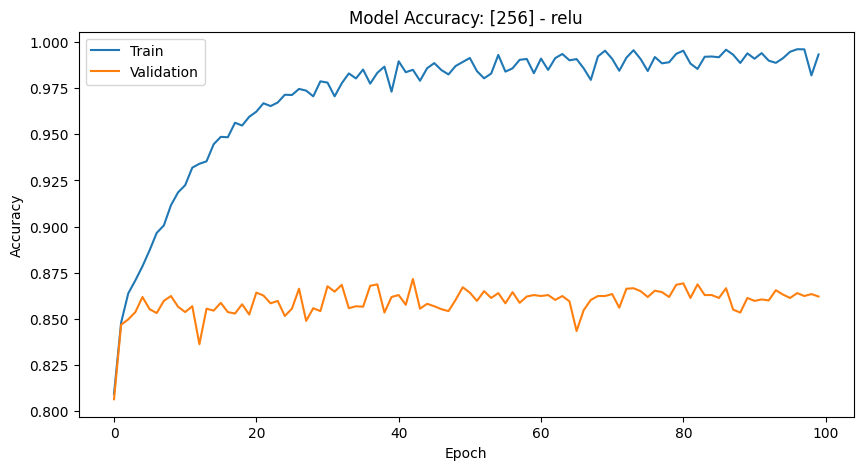


Testing architecture: [256] - sigmoid
Epoch 1/100
  Training    -> Loss: 0.4091 | Accuracy: 0.8119
  Validation  -> Loss: 0.3525 | Accuracy: 0.8332
Epoch 11/100
  Training    -> Loss: 0.2291 | Accuracy: 0.9052
  Validation  -> Loss: 0.3289 | Accuracy: 0.8569
Epoch 21/100
  Training    -> Loss: 0.1440 | Accuracy: 0.9442
  Validation  -> Loss: 0.3605 | Accuracy: 0.8548
Epoch 31/100
  Training    -> Loss: 0.0990 | Accuracy: 0.9629
  Validation  -> Loss: 0.4107 | Accuracy: 0.8540
Epoch 41/100
  Training    -> Loss: 0.0748 | Accuracy: 0.9724
  Validation  -> Loss: 0.4641 | Accuracy: 0.8535
Epoch 51/100
  Training    -> Loss: 0.0596 | Accuracy: 0.9781
  Validation  -> Loss: 0.5220 | Accuracy: 0.8524
Epoch 61/100
  Training    -> Loss: 0.0456 | Accuracy: 0.9844
  Validation  -> Loss: 0.5532 | Accuracy: 0.8577
Epoch 71/100
  Training    -> Loss: 0.0407 | Accuracy: 0.9853
  Validation  -> Loss: 0.5717 | Accuracy: 0.8542
Epoch 81/100
  Training    -> Loss: 0.0351 | Accuracy: 0.9882
  Validation

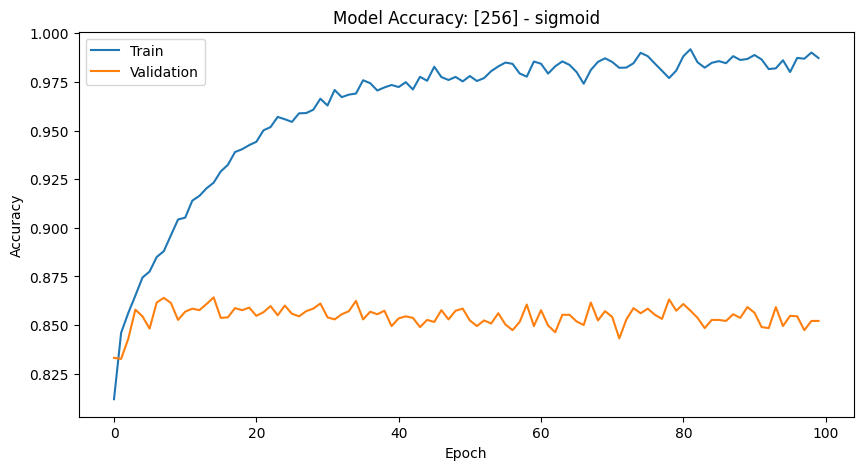


Testing architecture: [512] - relu
Epoch 1/100
  Training    -> Loss: 0.4313 | Accuracy: 0.8025
  Validation  -> Loss: 0.3564 | Accuracy: 0.8392
Epoch 11/100
  Training    -> Loss: 0.1971 | Accuracy: 0.9234
  Validation  -> Loss: 0.3740 | Accuracy: 0.8606
Epoch 21/100
  Training    -> Loss: 0.1138 | Accuracy: 0.9614
  Validation  -> Loss: 0.4997 | Accuracy: 0.8687
Epoch 31/100
  Training    -> Loss: 0.0652 | Accuracy: 0.9782
  Validation  -> Loss: 0.6478 | Accuracy: 0.8690
Epoch 41/100
  Training    -> Loss: 0.0573 | Accuracy: 0.9823
  Validation  -> Loss: 0.7732 | Accuracy: 0.8677
Epoch 51/100
  Training    -> Loss: 0.0243 | Accuracy: 0.9922
  Validation  -> Loss: 0.9452 | Accuracy: 0.8637
Epoch 61/100
  Training    -> Loss: 0.0520 | Accuracy: 0.9843
  Validation  -> Loss: 1.0097 | Accuracy: 0.8653
Epoch 71/100
  Training    -> Loss: 0.0335 | Accuracy: 0.9903
  Validation  -> Loss: 1.0013 | Accuracy: 0.8719
Epoch 81/100
  Training    -> Loss: 0.0147 | Accuracy: 0.9957
  Validation  -

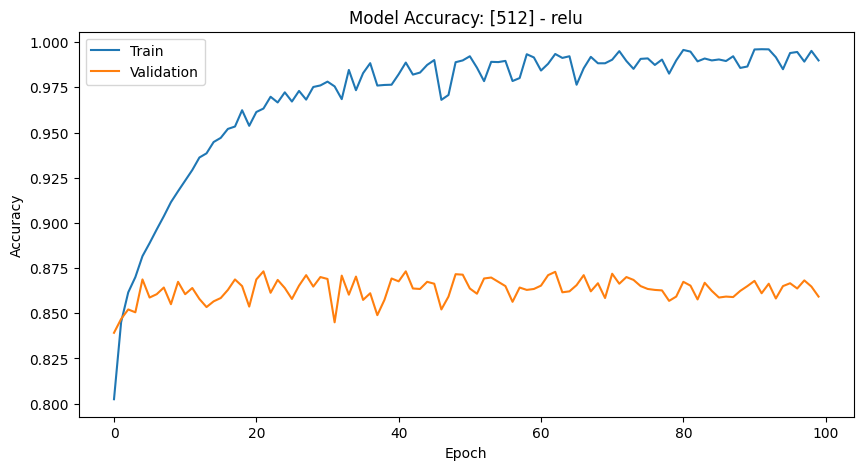


Testing architecture: [512] - sigmoid
Epoch 1/100
  Training    -> Loss: 0.4280 | Accuracy: 0.8016
  Validation  -> Loss: 0.3707 | Accuracy: 0.8332
Epoch 11/100
  Training    -> Loss: 0.2273 | Accuracy: 0.9065
  Validation  -> Loss: 0.3266 | Accuracy: 0.8571
Epoch 21/100
  Training    -> Loss: 0.1350 | Accuracy: 0.9502
  Validation  -> Loss: 0.3821 | Accuracy: 0.8540
Epoch 31/100
  Training    -> Loss: 0.0903 | Accuracy: 0.9678
  Validation  -> Loss: 0.4209 | Accuracy: 0.8513
Epoch 41/100
  Training    -> Loss: 0.0762 | Accuracy: 0.9725
  Validation  -> Loss: 0.4877 | Accuracy: 0.8484
Epoch 51/100
  Training    -> Loss: 0.0679 | Accuracy: 0.9746
  Validation  -> Loss: 0.5104 | Accuracy: 0.8490
Epoch 61/100
  Training    -> Loss: 0.0540 | Accuracy: 0.9796
  Validation  -> Loss: 0.5357 | Accuracy: 0.8513
Epoch 71/100
  Training    -> Loss: 0.0510 | Accuracy: 0.9805
  Validation  -> Loss: 0.5986 | Accuracy: 0.8508
Epoch 81/100
  Training    -> Loss: 0.0468 | Accuracy: 0.9829
  Validation

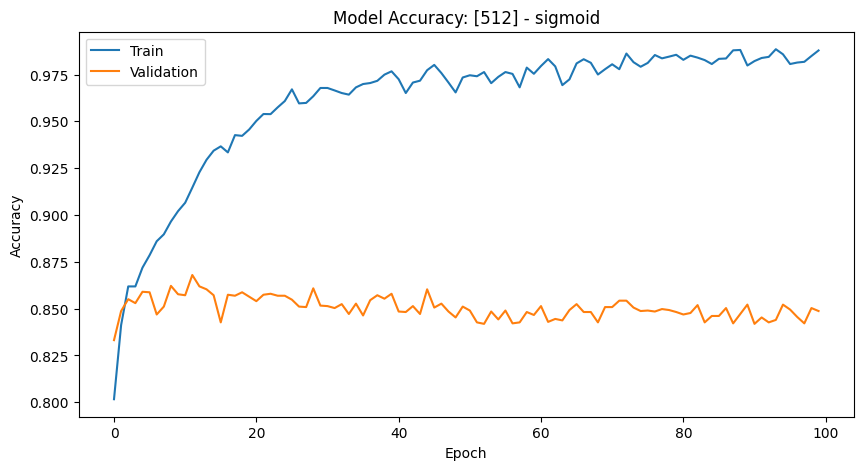


Testing architecture: [256, 128] - relu
Epoch 1/100
  Training    -> Loss: 0.4177 | Accuracy: 0.8009
  Validation  -> Loss: 0.3714 | Accuracy: 0.8358
Epoch 11/100
  Training    -> Loss: 0.1708 | Accuracy: 0.9269
  Validation  -> Loss: 0.3522 | Accuracy: 0.8682
Epoch 21/100
  Training    -> Loss: 0.0803 | Accuracy: 0.9684
  Validation  -> Loss: 0.5317 | Accuracy: 0.8616
Epoch 31/100
  Training    -> Loss: 0.0591 | Accuracy: 0.9794
  Validation  -> Loss: 0.6818 | Accuracy: 0.8664
Epoch 41/100
  Training    -> Loss: 0.0373 | Accuracy: 0.9863
  Validation  -> Loss: 0.8249 | Accuracy: 0.8761
Epoch 51/100
  Training    -> Loss: 0.0366 | Accuracy: 0.9868
  Validation  -> Loss: 0.8384 | Accuracy: 0.8687
Epoch 61/100
  Training    -> Loss: 0.0169 | Accuracy: 0.9942
  Validation  -> Loss: 1.0559 | Accuracy: 0.8556
Epoch 71/100
  Training    -> Loss: 0.0284 | Accuracy: 0.9907
  Validation  -> Loss: 1.1665 | Accuracy: 0.8616
Epoch 81/100
  Training    -> Loss: 0.0266 | Accuracy: 0.9911
  Validati

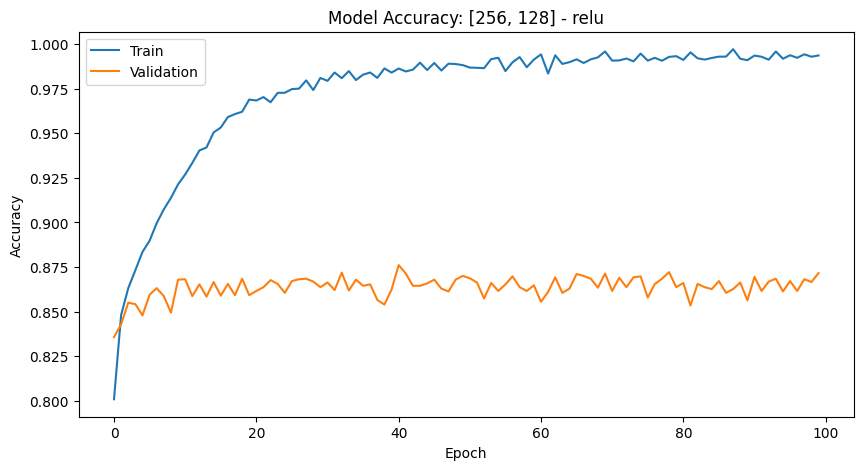


Testing architecture: [256, 128] - sigmoid
Epoch 1/100
  Training    -> Loss: 0.4152 | Accuracy: 0.8046
  Validation  -> Loss: 0.3674 | Accuracy: 0.8366
Epoch 11/100
  Training    -> Loss: 0.2230 | Accuracy: 0.9061
  Validation  -> Loss: 0.3625 | Accuracy: 0.8424
Epoch 21/100
  Training    -> Loss: 0.1546 | Accuracy: 0.9359
  Validation  -> Loss: 0.4400 | Accuracy: 0.8495
Epoch 31/100
  Training    -> Loss: 0.1141 | Accuracy: 0.9525
  Validation  -> Loss: 0.5084 | Accuracy: 0.8495
Epoch 41/100
  Training    -> Loss: 0.0848 | Accuracy: 0.9661
  Validation  -> Loss: 0.5902 | Accuracy: 0.8511
Epoch 51/100
  Training    -> Loss: 0.0699 | Accuracy: 0.9732
  Validation  -> Loss: 0.6550 | Accuracy: 0.8397
Epoch 61/100
  Training    -> Loss: 0.0639 | Accuracy: 0.9752
  Validation  -> Loss: 0.6809 | Accuracy: 0.8453
Epoch 71/100
  Training    -> Loss: 0.0644 | Accuracy: 0.9751
  Validation  -> Loss: 0.7173 | Accuracy: 0.8361
Epoch 81/100
  Training    -> Loss: 0.0515 | Accuracy: 0.9809
  Valid

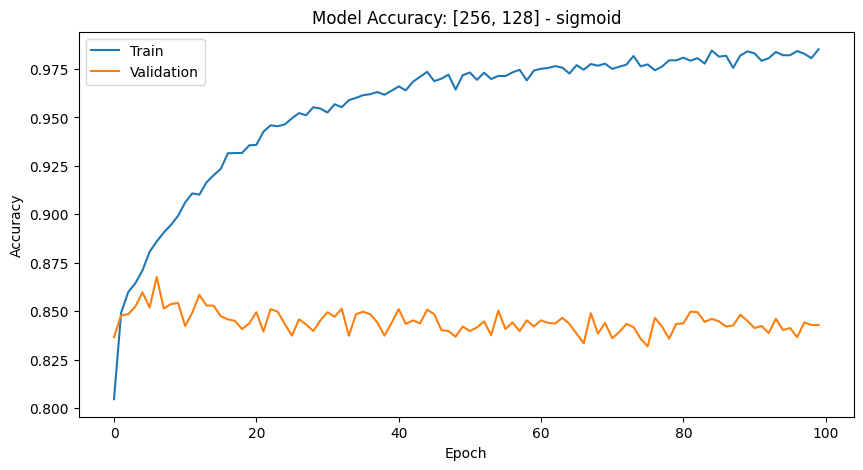


Testing architecture: [512, 256] - relu
Epoch 1/100
  Training    -> Loss: 0.4163 | Accuracy: 0.8047
  Validation  -> Loss: 0.3744 | Accuracy: 0.8231
Epoch 11/100
  Training    -> Loss: 0.1552 | Accuracy: 0.9357
  Validation  -> Loss: 0.4042 | Accuracy: 0.8558
Epoch 21/100
  Training    -> Loss: 0.0739 | Accuracy: 0.9699
  Validation  -> Loss: 0.6121 | Accuracy: 0.8648
Epoch 31/100
  Training    -> Loss: 0.0436 | Accuracy: 0.9834
  Validation  -> Loss: 0.7822 | Accuracy: 0.8553
Epoch 41/100
  Training    -> Loss: 0.0379 | Accuracy: 0.9861
  Validation  -> Loss: 0.8431 | Accuracy: 0.8666
Epoch 51/100
  Training    -> Loss: 0.0317 | Accuracy: 0.9891
  Validation  -> Loss: 1.0565 | Accuracy: 0.8587
Epoch 61/100
  Training    -> Loss: 0.0262 | Accuracy: 0.9910
  Validation  -> Loss: 1.0796 | Accuracy: 0.8598
Epoch 71/100
  Training    -> Loss: 0.0301 | Accuracy: 0.9897
  Validation  -> Loss: 1.0149 | Accuracy: 0.8582
Epoch 81/100
  Training    -> Loss: 0.0269 | Accuracy: 0.9908
  Validati

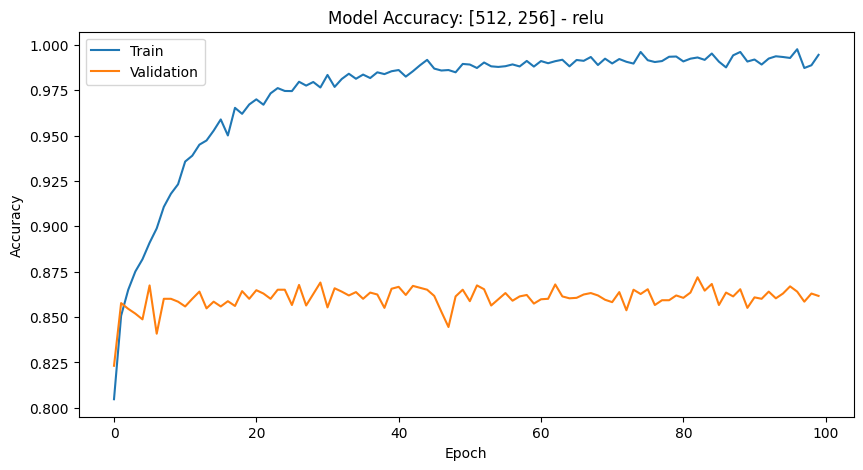


Testing architecture: [512, 256] - sigmoid
Epoch 1/100
  Training    -> Loss: 0.4195 | Accuracy: 0.7994
  Validation  -> Loss: 0.3501 | Accuracy: 0.8426
Epoch 11/100
  Training    -> Loss: 0.2173 | Accuracy: 0.9067
  Validation  -> Loss: 0.3502 | Accuracy: 0.8569
Epoch 21/100
  Training    -> Loss: 0.1431 | Accuracy: 0.9407
  Validation  -> Loss: 0.4305 | Accuracy: 0.8463
Epoch 31/100
  Training    -> Loss: 0.1077 | Accuracy: 0.9578
  Validation  -> Loss: 0.4886 | Accuracy: 0.8511
Epoch 41/100
  Training    -> Loss: 0.0853 | Accuracy: 0.9653
  Validation  -> Loss: 0.5716 | Accuracy: 0.8445
Epoch 51/100
  Training    -> Loss: 0.0736 | Accuracy: 0.9707
  Validation  -> Loss: 0.6275 | Accuracy: 0.8453
Epoch 61/100
  Training    -> Loss: 0.0713 | Accuracy: 0.9719
  Validation  -> Loss: 0.5848 | Accuracy: 0.8484
Epoch 71/100
  Training    -> Loss: 0.0624 | Accuracy: 0.9758
  Validation  -> Loss: 0.6286 | Accuracy: 0.8556
Epoch 81/100
  Training    -> Loss: 0.0532 | Accuracy: 0.9784
  Valid

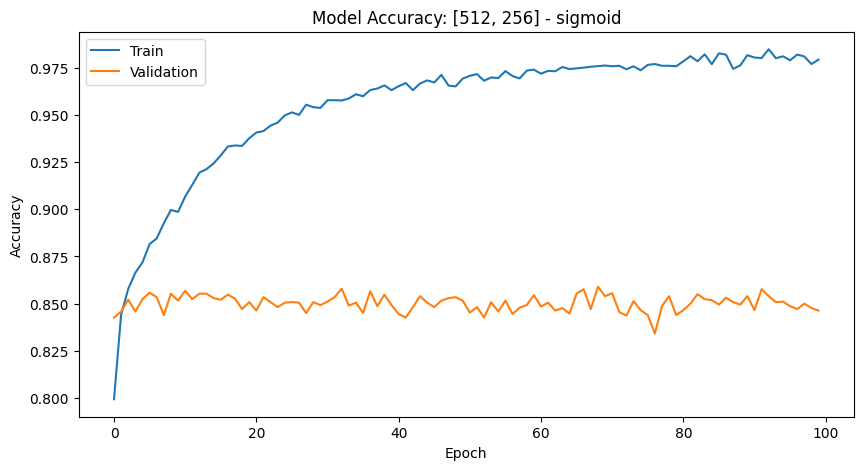


Test Results:
----------------------------------------
[256] - relu: 0.8621
[256] - sigmoid: 0.8488
[512] - relu: 0.8547
[512] - sigmoid: 0.8499
[256, 128] - relu: 0.8629
[256, 128] - sigmoid: 0.8463
[512, 256] - relu: 0.8623
[512, 256] - sigmoid: 0.8351

Best Model: [256, 128] - relu
Best Test Accuracy: 0.8629


In [17]:
def main():
   data_dir = "UTKFace/UTKFace"
   X, y = load_and_preprocess_data(data_dir)

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

   train_dataset = LoadDataset(X_train, y_train)
   val_dataset = LoadDataset(X_val, y_val)
   test_dataset = LoadDataset(X_test, y_test)

   batch_size = 32
   train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
   val_loader = DataLoader(val_dataset, batch_size=batch_size)
   test_loader = DataLoader(test_dataset, batch_size=batch_size)

   architectures = [
    {'hidden_layers': [256], 'activation': 'relu'},
    {'hidden_layers': [256], 'activation': 'sigmoid'},
    {'hidden_layers': [512], 'activation': 'relu'},
    {'hidden_layers': [512], 'activation': 'sigmoid'},
    {'hidden_layers': [256, 128], 'activation': 'relu'},
    {'hidden_layers': [256, 128], 'activation': 'sigmoid'},
    {'hidden_layers': [512, 256], 'activation': 'relu'},
    {'hidden_layers': [512, 256], 'activation': 'sigmoid'}
]

   results = []
   for config in architectures:
       print(f"\nTesting architecture: {config['hidden_layers']} - {config['activation']}")

       model = NeuralNetwork(
           input_size=4096,
           hidden_layers=config['hidden_layers'],
           activation=config['activation']
       ).to(device)

       history = train(model, train_loader, val_loader, device, epochs=100, learning_rate=0.001)
       test_acc = evaluate(model, test_loader, device)

       results.append({
           'architecture': config,
           'test_accuracy': test_acc,
           'history': history
       })

       plt.figure(figsize=(10, 5))
       plt.plot(history['train_acc'], label='Train')
       plt.plot(history['val_acc'], label='Validation')
       plt.title(f"Model Accuracy: {config['hidden_layers']} - {config['activation']}")
       plt.xlabel('Epoch')
       plt.ylabel('Accuracy')
       plt.legend()
       plt.show()

   print("\nTest Results:")
   print("-" * 40)
   for result in results:
       config = result['architecture']
       print(f"{config['hidden_layers']} - {config['activation']}: {result['test_accuracy']:.4f}")

   best_result = max(results, key=lambda x: x['test_accuracy'])
   print(f"\nBest Model: {best_result['architecture']['hidden_layers']} - {best_result['architecture']['activation']}")
   print(f"Best Test Accuracy: {best_result['test_accuracy']:.4f}")

if __name__ == "__main__":
   main()

Best Model: [256, 128] - relu \
Best Test Accuracy: 0.8629

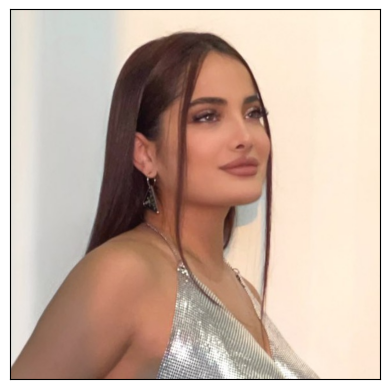

Predicted gender is: Female


In [36]:
input_size = 64 * 64
hidden_layers = [256, 128]
num_classes = 2
activation = 'relu'
model = NeuralNetwork(input_size, hidden_layers, num_classes, activation).to(device)

def predict_gender(image_path, model, device):
    try:
        img = Image.open(image_path).convert("RGB").resize((64, 64))
        x_array = np.array(img) / 255.0
        x_array = x_array.mean(axis=2)
        x_tensor = torch.tensor(x_array, dtype=torch.float32).unsqueeze(0).view(-1, 64 * 64).to(device)

        with torch.no_grad():
            gender_prediction = model(x_tensor)
            predicted_class = torch.argmax(gender_prediction, dim=1).item()
        show_img = Image.open(image_path)
        plt.imshow(show_img)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print("Predicted gender is:", "Male" if predicted_class == 0 else "Female")

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

predict_gender("woman1.jpg", model, device)
